# S3 Geology

**Structural uncertainty due to fault timing: a multi-model case study from the Perth Basin**<br><br>Bardot, K., Lesueur, M., Siade, A. J., Lang, S. C. and McCallum, J. L. (2024)

In [33]:
%run ./S1_routines.ipynb
%run ./S2_variables.ipynb

routines run


### Import raw data

In [10]:
# read in csv file of formation picks
df = pd.read_csv('stratigraphy.csv') # Read in csv file
data_headings = df.columns.values.tolist() # Convert headings to a list
formation_list = data_headings[4:]         # Make a list of formations  
data_list = df.values.tolist()             # Turn data into a list of lists

AM75 = Bore(df.iloc[0].Easting, df.iloc[0].Northing, df.iloc[0].Ground)
YMB1 = Bore(df.iloc[1].Easting, df.iloc[1].Northing, df.iloc[1].Ground)
AM72 = Bore(df.iloc[2].Easting, df.iloc[2].Northing, df.iloc[2].Ground)

AM75.x = 5000. # 500 for original
YMB1.x = np.sqrt((AM75.easting - YMB1.easting)**2 + (AM75.northing - YMB1.northing)**2) + AM75.x
AM72.x = np.sqrt((AM72.easting - YMB1.easting)**2 + (AM72.northing - YMB1.northing)**2) + YMB1.x
bore_loc = [0., AM75.x, YMB1.x, AM72.x, xmax]

AM75.super = AM75.ground - df.iloc[0].Kcom
AM75.kcok  = AM75.ground - df.iloc[0].Kcok
AM75.kwlp  = AM75.ground - df.iloc[0].Kwlp
AM75.kwlw  = AM75.ground - df.iloc[0].Kwlw
AM75.kwlm  = AM75.ground - df.iloc[0].Kwlm
AM75.kws   = AM75.ground - df.iloc[0].Kws
AM75.kwg   = AM75.ground - df.iloc[0].Kws # no Gage
AM75.jy    = AM75.ground - df.iloc[0].Jy

YMB1.super = YMB1.ground - df.iloc[1].Kcom
YMB1.kcok  = YMB1.ground - df.iloc[1].Kcom # no Kardinya
YMB1.kwlp  = YMB1.ground - df.iloc[1].Kwlp
YMB1.kwlw  = YMB1.ground - df.iloc[1].Kwlw
YMB1.kwlm  = YMB1.ground - df.iloc[1].Kwlm
YMB1.kws   = YMB1.ground - df.iloc[1].Kws
YMB1.kwg   = YMB1.ground - df.iloc[1].Kwg
YMB1.jy    = YMB1.ground - df.iloc[1].Jy

AM72.super = AM72.ground - df.iloc[2].Kcm
AM72.kcok  = AM72.ground - df.iloc[2].Kcm # no Kardinya
AM72.kwlp  = AM72.ground - df.iloc[2].Kwlp
AM72.kwlw  = AM72.ground - df.iloc[2].Kwlw
AM72.kwlm  = AM72.ground - df.iloc[2].Kwlw # No Maringiniup
AM72.kws   = AM72.ground - df.iloc[2].Kws
AM72.kwg   = AM72.ground - df.iloc[2].Kwg
AM72.jy    = AM72.ground - df.iloc[2].Jy

stratigraphy = ['super', 'kcok', 'kwlp', 'kwlw', 'kwlm', 'kws', 'kwg', 'jy']
nlith = len(stratigraphy)
fault_scenarios = ([False, False, False, False, False, False, False, True],
                   [False, False, False, False, False, True, True, True],
                   [False, False, True, True, True, True, True, True])

### Examining offset in Stratigraphy between AM72 and YMB1

In [11]:
import math
display = False
if display:
    print('South Perth Shale Thickness in AM72 is ',(AM72.kwlm - AM72.kws))
    print('South Perth Shale Thickness in YMB1 is ',(YMB1.kwlm - YMB1.kws))
    print('Distance between YMB1 and AM72 is ',(YMB1.x - AM72.x))
    print('Equivalent fold slope is ', math.degrees(math.atan((YMB1.kws - AM72.kws) / (YMB1.x - AM72.x))))

### Setting up arrays for flow model

In [12]:
# LOOPING FOR ALL MODELS
layers_all, fault_top_all, mid_formation, bot_strat_all = [],[], [], []
hk_all, vk_all, angle2_all = [], [], []
ss_all, hfb_all = [], []

for model in range(3): # THREE STRUCTURAL MODELS
        faulted = fault_scenarios[model]     
        hk = hk_by_layer
        vk = vk_by_layer
        
        fault_top = 0.
        for i in range(nlith):
            strat = stratigraphy[i]
            while faulted[i] == False:
                fault_top = getattr(YMB1, strat)
                break

        kind, fill_value = 'linear', "extrapolate"
        f = interp1d(bore_loc, [AM75.ground, AM75.ground, YMB1.ground, AM72.ground, AM72.ground], 
                     kind = kind, fill_value=fill_value) 
        groundlevel = f(xi)
        bot_stratigraphy = [None] * nlith # Create empty list of length nlith
        angle2_stratigraphy = [None] * nlith

        for i in range(len(faulted)):
            strat = stratigraphy[i]

            if faulted[i] == False:
                x_raw = [AM75.x, YMB1.x, fault_x, AM72.x, xmax]
                y_raw = [getattr(AM75, strat), getattr(YMB1, strat), getattr(YMB1, strat), getattr(AM72, strat), getattr(AM72, strat)]
                f = interp1d(x_raw, y_raw, kind = kind, fill_value=fill_value)        
                bot_stratigraphy[i] = f(xi)
                angle2_stratigraphy[i] = [grad_to_deg(c) for c in np.gradient(bot_stratigraphy[i], delr)]

            else:
                bot_stratigraphy[i], angle2_stratigraphy[i] = faulted_bot_strat(xi, xmax, getattr(AM75, strat), 
                                                                                getattr(YMB1, strat), getattr(AM72, strat), strat)

        bot_stratigraphy[-1], angle2_stratigraphy[-1] = zmin * np.ones((ncol)), np.zeros((ncol)) # Last layer Yarragadee  
       
        A = Model(nlay, nrow, ncol)
        A.top[0,:] = groundlevel # TOP
        for lay in range(A.nlay): # BOT
            A.bot[lay,:,:] = zi[lay]
        A.rch = [] # RCH 


        for i in range(A.ncol): # LAYER IDS, IDOMAIN, RECHARGE
            for j in range(A.nrow):
                k = 0 # k is model layer
                A.layers[k:-1,j,i] = int(0)
                while A.bot[k,j,i] > A.top[j,i]: # Above land surface
                    
                    A.layers[k,j,i] = int(-1)
                    A.idomain[k,j,i] = 0
                    k+=1
                if i != 0 and i != ncol-1: # Assign recharge to the top active layer
                    A.rch.append(((k+1, j, i), recharge_rate))
                for n in range(nlith-1): # For each PRAMS layer
                    #print('i j k n = ',i, j, k, n)
                    while A.bot[k,j,i] > bot_stratigraphy[n][i]: # n is geo layer, i is column
                        #print('i j k n = ',i, j, k, n)
                        #print(A.bot[k,j,i], bot_stratigraphy[n][i]) 
                        A.layers[k+1:,j,i] = int(n)
                        k+=1
                A.layers[k:,j,i] = int(nlith-1)

        hk_array, vk_array, ss_array, angle2_array = np.copy(A.layers), np.copy(A.layers), np.copy(A.layers), np.copy(A.layers)
        hk_array[hk_array == -1] = 999999 # above ground
        vk_array[vk_array == -1] = 999999 # above ground
        
        for lith in range(nlith): # HK / VK/ SS
            hk_array[hk_array == lith] = hk[lith]
            vk_array[vk_array == lith] = vk[lith]
            ss_array[ss_array == lith] = ss[lith]

        for i in range(ncol):
            for lith in range(nlith):
                pillar = angle2_array[:,0,i] # Essentially take a pillar by columns of layer IDs
                pillar[pillar == lith] = angle2_stratigraphy[lith][i] # Replace layer ID pillar with Angle2
                angle2_array[:,0,i] = pillar # Substitue pillar back into angle2 array
               
        f = interp1d(west_HB_z, west_HB_h, kind = 'linear', fill_value=fill_value) # CHD
        ch_west = f(zc)
        f = interp1d(east_HB_z, east_HB_h, kind = 'linear', fill_value=fill_value) 
        ch_east = f(zc)

        A.chd = []  # CHD
        for k in range(A.nlay):
            if A.idomain[k,0,0] != 0:
                A.chd.append(((k, 0, 0), ch_west[k]))
            if A.idomain[k,0,ncol-1] != 0:
                A.chd.append(((k, 0, ncol-1), ch_east[k]))

        fault_top_all.append(fault_top)
        layers_all.append(A.layers)
        bot_strat_all.append(bot_stratigraphy)
        
        hk_all.append(hk_array)
        vk_all.append(vk_array)
        ss_all.append(ss_array)
        angle2_all.append(angle2_array)
        
        a = bot_stratigraphy[1] + (A.top - bot_stratigraphy[1])/2 # superficial
        b = bot_stratigraphy[3] + (bot_stratigraphy[2] - bot_stratigraphy[3])/2 # pinjar
        c = bot_stratigraphy[6] - 150 # upper yarr
        mid_formation.append((a[0], b, c)) 

### Set up Colormap

In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.colors
colors = [(1., 1., 1.),
          (1., 1., 0.), # Superficial
          (0.8, 0.8, 0.), # Coolyena
          (0.8, 1, 0.2), # Pinjar
          (0.6, 0.8, 0.), # Wanneroo
          (0.4, 0.6, 0.), #Maringiniup
          (0.58, 0.54, 0.33), # SP Shale
          (0.31, 0.38, 0.2), # Gage Sandstone
          (0.33, 0.55, 0.83)] # Yarragadee

cmap = ListedColormap(colors, name='perth_geo')

vals = np.unique(A.layers)
col_dict={-1:"white", 0:"gold", 1:"lightsalmon",2:"greenyellow",3:"yellowgreen", 
          4:"olivedrab", 5:"darkkhaki", 6:"darkolivegreen", 7:"royalblue"}
#labels = np.array(["sky","Super","Kcok","Kwlp","Kwlw", "Kwlm", "Kws", "Kwg", "Jy"])
labels = np.array(["sky","Superficial Formation (AQUIFER)",
                   "Kardinya Shale (AQUITARD)",
                   "Pinjar (AQUIFER)",
                   "Wanneroo (AQUIFER)", 
                   "Maringiniup (AQUIFER)", 
                   "South Perth Shale (AQUITARD)", 
                   "Gage (AQUIFER)", 
                   "Yarragadee (AQUIFER)"])
len_lab = len(labels)

norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

### Import Gamma Logs

In [14]:
import lasio

well = lasio.read('../las/AM72.las')
df_AM72 = well.df()
df_AM72['DEPT'] = df_AM72.index

well = lasio.read('../las/AM75.las')
df_AM75 = well.df()
df_AM75['DEPT'] = df_AM75.index

well = lasio.read('../las/YMB1.las')
df_YMB1 = well.df()
df_YMB1['DEPT'] = df_YMB1.index

well = lasio.read('../las/1_07.las')
df_1_07 = well.df()
df_1_07['DEPT'] = df_1_07.index

### Producing figure

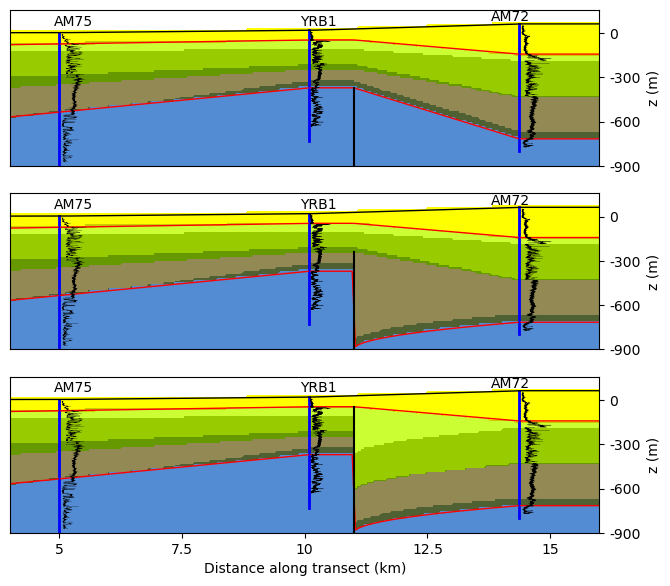

In [32]:
display = True
if display:
    fig, axes = plt.subplots(3,1, figsize=(6.75, 6))
    for i, ax in enumerate(axes.flat): 
        array = layers_all[i][:,0,:]
        im = ax.imshow(array, aspect = 3, cmap=cmap, norm=norm, extent = [0,xmax,zmin, zmax]) # Was 6
        diff = norm_bins[1:] - norm_bins[:-1]
        tickz = norm_bins[:-1] + diff / 2

        ax.plot([AM75.x, AM75.x],[AM75.ground, AM75.jy], color = 'blue', lw = 2.)
        ax.plot([YMB1.x, YMB1.x],[YMB1.ground, YMB1.jy], color = 'blue', lw = 2.)
        ax.plot([AM72.x, AM72.x],[AM72.ground, AM72.jy], color = 'blue', lw = 2.)
        ax.set_ylim([-900, zmax+60])
        ax.set_xlim([4000, 16000])
        if i == 2: ax.set_xlabel('Distance along transect (km)', size = 10)
        ax.set_xticks([5000, 7500, 10000, 12500, 15000])
        ax.set_xticklabels(labels = [5, 7.5, 10, 12.5, 15], size = 10)
        if i ==0 or i ==1: ax.set_xticks([])
        ax.set_ylabel('z (m)', size = 10)
        ax.set_yticks([-900,-600, -300, 0])
        ax.set_yticklabels(labels = [-900,-600, -300, 0], size =10)
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        #ax.set_title(titles[i], size = 9)
        ax.plot(xi,bot_strat_all[i][1], color = 'red', lw = 1)  
        ax.plot(xi,bot_strat_all[i][6], color = 'red', lw = 1) 
        ax.plot([fault_x, fault_x],[-1000, fault_top_all[i]], color='black', lw = 1.5)
        ax.plot([AM75.x, AM75.x],[AM75.ground, AM75.jy], color = 'blue', lw = 1.)
        ax.plot([YMB1.x, YMB1.x],[YMB1.ground, YMB1.jy], color = 'blue', lw = 1.)
        ax.plot([AM72.x, AM72.x],[AM72.ground, AM72.jy], color = 'blue', lw = 1.)
        ax.annotate("AM75",(4900, AM75.ground+50), size = 10)#, bbox=dict(facecolor = 'white'))
        ax.annotate("YRB1",(9900, AM75.ground+50), size = 10)#, bbox=dict(facecolor = 'white'))
        ax.annotate("AM72",(13800, AM75.ground+80), size = 10)#, bbox=dict(facecolor = 'white'))
        ax.plot(xc, groundlevel, lw = 1., color = 'black')
        ax.plot(AM72.x + 2*np.array(df_AM72['GAMM']), AM72.ground + np.array(-1*df_AM72['DEPT']), color = 'black', lw = 0.1)
        ax.plot(AM75.x + 2*np.array(df_AM75['GAMM']), AM75.ground + np.array(-1*df_AM75['DEPT']), color = 'black', lw = 0.1)
        ax.plot(YMB1.x + 2*np.array(df_1_07['GAMM'][:340]), YMB1.ground + np.array(-1*df_1_07['DEPT'][:340]), color = 'black', lw = 0.2)
        ax.plot(YMB1.x + 3*np.array(df_YMB1['GAMM'][340:]), YMB1.ground + np.array(-1*df_YMB1['DEPT'][340:]), color = 'black', lw = 0.2)
    plt.tight_layout()
    plt.show()
    fig.savefig('../figures/fig3.tif', dpi=300)


### Setting up observation points

In [8]:
obs_x = [AM75.x, AM72.x]
obs_bore_ids = ['OB1_Sup', 'OB1_Pin', 'OB2_Sup', 'OB2_Pin'] # OBS BORES

obs_cells, obs_coords = [], []

#OBS1 - AM75 shallow
x, z = AM75.x, AM75.kwlp
col, lay = x_to_col(x, delr), z_to_lay(z, delz, zmax) 
obs_coords.append((x,z)) 
obs_cells.append((lay,0,col)) 

#OBS2 - YMB1 shallow
x, z = YMB1.x, YMB1.kwlp
col, lay = x_to_col(x, delr), z_to_lay(z, delz, zmax) 
obs_coords.append((x,z)) 
obs_cells.append((lay,0,col)) 

#OBS3 - AM72 shallow
x, z = AM72.x, AM72.kwlp
col, lay = x_to_col(x, delr), z_to_lay(z, delz, zmax) 
obs_coords.append((x,z)) 
obs_cells.append((lay,0,col)) 

#OBS4 - AM75 deep
x, z = AM75.x, AM75.jy
col, lay = x_to_col(x, delr), z_to_lay(z, delz, zmax) 
obs_coords.append((x,z)) 
obs_cells.append((lay,0,col)) 

#OBS5 - AM72 deep
x, z = AM72.x, AM72.jy
col, lay = x_to_col(x, delr), z_to_lay(z, delz, zmax) 
obs_coords.append((x,z)) 
obs_cells.append((lay,0,col)) 

#OBS6 - NEar fault
x = fault_x + 500.
col = x_to_col(x, delr)
z = mid_formation[0][0][col]
lay = z_to_lay(z, delz, zmax) 
obs_coords.append((x,z)) 
obs_cells.append((lay,0,col)) 

obs_gwf_recarray, obs_gwt_recarray = [], []
for model in range(3):    
    obs_gwf = {"head_obs.csv": [
            ("obs1", "HEAD", obs_cells[0]),
            ("obs2", "HEAD", obs_cells[1]),
            ("obs3", "HEAD", obs_cells[2]),
            ("obs4", "HEAD", obs_cells[3]),
            ("obs5", "HEAD", obs_cells[4]),],}

    obs_gwt = {"conc_obs.csv": [
            ("obs1", "CONCENTRATION", obs_cells[0]),
            ("obs2", "CONCENTRATION", obs_cells[1]),
            ("obs3", "CONCENTRATION", obs_cells[2]),
            ("obs4", "CONCENTRATION", obs_cells[3]),
            ("obs5", "CONCENTRATION", obs_cells[4]),],}
    obs_gwf_recarray.append(obs_gwf)
    obs_gwt_recarray.append(obs_gwt)